In [19]:
!pip uninstall xgboost lightgbm -y

Found existing installation: xgboost 3.0.2
Uninstalling xgboost-3.0.2:
  Successfully uninstalled xgboost-3.0.2
Found existing installation: lightgbm 4.6.0
Uninstalling lightgbm-4.6.0:
  Successfully uninstalled lightgbm-4.6.0


You can safely remove it manually.
You can safely remove it manually.


In [20]:
!pip install lightgbm==3.3.2 --no-cache-dir

   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   -------------------- ------------------- 0.5/1.0 MB 764.3 kB/s eta 0:00:01
   -------------------- ------------------- 0.5/1.0 MB 764.3 kB/s eta 0:00:01
   ------------------------------ --------- 0.8/1.0 MB 799.2 kB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 849.7 kB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import joblib

In [13]:
from lightgbm import LGBMRegressor, plot_importance
import matplotlib.pyplot as plt

In [3]:
# Load data
df = pd.read_excel('Training.xlsx', sheet_name='Sheet1')

# Feature selection
features = [
    'Demand_Multiplier_res',
    'Occ_Rate_Res',
    'Fixed_Cost',
    'Region',
    'Nbre-Etoile'
]
target = 'Paid_Price'


In [4]:
# Encode categorical variable
le = LabelEncoder()
df['Region'] = le.fit_transform(df['Region'])

# Split data
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [5]:
# LightGBM dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Model parameters
params = {
    'objective': 'regression',
    'metric': ['mae', 'rmse'],
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,  # -1 means no limit
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbose': -1,
    'random_state': 42
}

In [6]:
# Train model
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=2000,
    early_stopping_rounds=50,
    verbose_eval=50
)

C:\Users\DELL\anaconda3\Lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DELL\anaconda3\Lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[50]	training's l1: 61.3413	training's rmse: 75.1412	valid_1's l1: 61.6603	valid_1's rmse: 75.4826
[100]	training's l1: 52.6896	training's rmse: 64.4853	valid_1's l1: 52.8627	valid_1's rmse: 64.7374
[150]	training's l1: 49.2155	training's rmse: 60.3995	valid_1's l1: 49.3548	valid_1's rmse: 60.6276
[200]	training's l1: 46.4718	training's rmse: 57.1533	valid_1's l1: 46.5769	valid_1's rmse: 57.3529
[250]	training's l1: 44.4181	training's rmse: 54.906	valid_1's l1: 44.5058	valid_1's rmse: 55.0791
[300]	training's l1: 42.4305	training's rmse: 52.71	valid_1's l1: 42.5038	valid_1's rmse: 52.8625
[350]	training's l1: 40.8056	training's rmse: 50.9107	valid_1's l1: 40.8667	valid_1's rmse: 51.046
[400]	training's l1: 39.4554	training's rmse: 49.489	valid_1's l1: 39.5193	valid_1's rmse: 49.6167
[450]	training's l1: 38.2715	training's rmse: 48.2287	valid_1's l1: 38.3372	valid_1's rmse: 48.3474
[500]	training's l1: 37.2819	training's rmse:

In [7]:
# Evaluate
y_pred = model.predict(X_test)
print(f"\nMAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")



MAE: 27.86
RMSE: 37.14
R²: 0.9780


In [8]:
# Save model and encoder
model.save_model('hotel_pricing_lgbm_model.json')
joblib.dump(le, 'region_encoder_lgbm.pkl')

['region_encoder_lgbm.pkl']

<Figure size 1000x600 with 0 Axes>

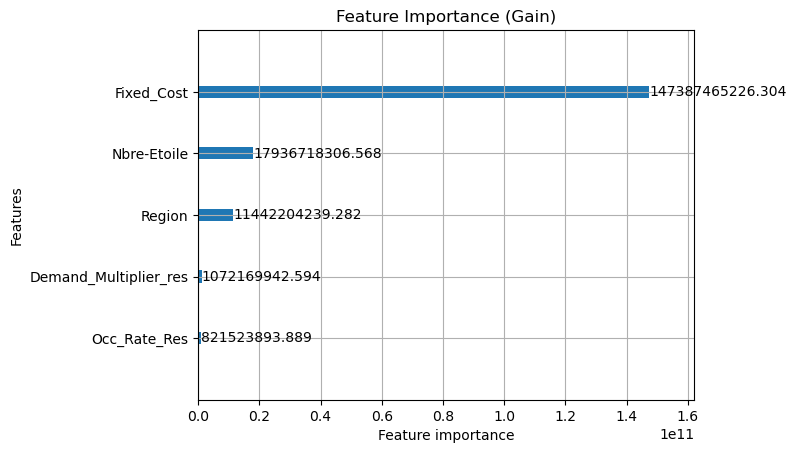


Feature Importance Scores:
                 Feature    Importance
2             Fixed_Cost  1.473875e+11
4            Nbre-Etoile  1.793672e+10
3                 Region  1.144220e+10
0  Demand_Multiplier_res  1.072170e+09
1           Occ_Rate_Res  8.215239e+08


In [14]:
# Feature Importance Visualization
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, importance_type='gain', max_num_features=10)
plt.title('Feature Importance (Gain)')
plt.show()

# Numeric Feature Importance
importance = model.feature_importance(importance_type='gain')
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importance
}).sort_values('Importance', ascending=False)

print("\nFeature Importance Scores:")
print(feature_importance)

In [9]:
# Prediction function
def predict_hotel_price_lgbm(input_features):
    """
    Predict hotel price using LightGBM model
    
    Args:
        input_features (dict): {
            'Demand_Multiplier_res': float,
            'Occ_Rate_Res': float,
            'Fixed_Cost': float,
            'Region': str  # Original region name
            'Nbre-Etoile'
        }
    
    Returns:
        float: Predicted price
    """
    # Load model and encoder
    model = lgb.Booster(model_file='hotel_pricing_lgbm_model.json')
    le = joblib.load('region_encoder_lgbm.pkl')
    
    # Convert to DataFrame
    input_df = pd.DataFrame([input_features])
    
    # Encode region (handle unseen categories)
    try:
        input_df['Region'] = le.transform(input_df['Region'])
    except ValueError:
        # Assign unknown region code if not found
        input_df['Region'] = len(le.classes_)
    
    # Ensure correct feature order
    input_df = input_df[features]
    
    # Predict
    return float(model.predict(input_df)[0])

In [11]:
 example_input = {
        'Demand_Multiplier_res': 1.48,
        'Occ_Rate_Res': 0.46,
        'Fixed_Cost': 100,
        'Region': 'Mahdia',
        'Nbre-Etoile':3
    }

In [12]:
predicted_price = predict_hotel_price_lgbm(example_input)
print(f"\nPredicted price: {predicted_price:.2f}TND")


Predicted price: 354.05TND


In [15]:
import xgboost as xgb

In [16]:
# Create DMatrix for XGBoost (optimized data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [17]:
# XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': ['mae', 'rmse'],
    'learning_rate': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': 42
}

In [18]:
# Train model
evals_result = {}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=50,
    evals_result=evals_result,
    verbose_eval=50
)

[0]	train-mae:166.47219	train-rmse:237.20401	test-mae:167.61753	test-rmse:238.83246
[50]	train-mae:60.02780	train-rmse:73.31071	test-mae:60.28482	test-rmse:73.60832
[100]	train-mae:53.28280	train-rmse:65.58368	test-mae:53.42626	test-rmse:65.81536
[150]	train-mae:50.10083	train-rmse:61.87577	test-mae:50.27612	test-rmse:62.15372
[200]	train-mae:47.74784	train-rmse:59.25088	test-mae:47.96332	test-rmse:59.57152
[250]	train-mae:45.65358	train-rmse:56.95626	test-mae:45.88198	test-rmse:57.29669
[300]	train-mae:43.56669	train-rmse:54.57685	test-mae:43.81038	test-rmse:54.94475
[350]	train-mae:41.91615	train-rmse:52.71020	test-mae:42.15713	test-rmse:53.07646
[400]	train-mae:40.57769	train-rmse:51.22356	test-mae:40.83276	test-rmse:51.61067
[450]	train-mae:39.35950	train-rmse:49.85572	test-mae:39.63886	test-rmse:50.25974
[500]	train-mae:38.18295	train-rmse:48.51080	test-mae:38.47668	test-rmse:48.92268
[550]	train-mae:37.04550	train-rmse:47.25538	test-mae:37.35227	test-rmse:47.67646
[600]	train-mae

In [19]:
# Evaluate
y_pred = model.predict(dtest)
print(f"\nMAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")


MAE: 28.35
RMSE: 38.13
R²: 0.9768


<Figure size 1000x600 with 0 Axes>

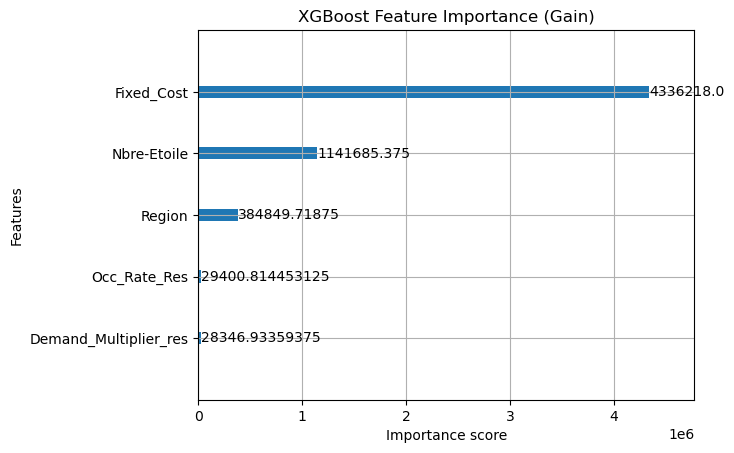


Feature Importance Scores:
                 Feature    Importance
2             Fixed_Cost  4.336218e+06
4            Nbre-Etoile  1.141685e+06
3                 Region  3.848497e+05
1           Occ_Rate_Res  2.940081e+04
0  Demand_Multiplier_res  2.834693e+04


In [20]:
# Feature Importance Visualization
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='gain', max_num_features=10)
plt.title('XGBoost Feature Importance (Gain)')
plt.show()

# Numeric Feature Importance
importance = model.get_score(importance_type='gain')
feature_importance = pd.DataFrame({
    'Feature': importance.keys(),
    'Importance': importance.values()
}).sort_values('Importance', ascending=False)

print("\nFeature Importance Scores:")
print(feature_importance)

In [ ]:
# Prediction function
def predict_hotel_price_xgb(input_features):
    """
    Predict hotel price using XGBoost model
    
    Args:
        input_features (dict): {
            'Demand_Multiplier_res': float,
            'Occ_Rate_Res': float,
            'Fixed_Cost': float,
            'Region': str  # Original region name
        }
    
    Returns:
        float: Predicted price
    """
    # Load model and encoder
    model = xgb.Booster()
    model.load_model('hotel_pricing_xgb.json')
    le = joblib.load('region_encoder_xgb.pkl')
    
    # Convert to DataFrame
    input_df = pd.DataFrame([input_features])
    
    # Encode region (handle unseen categories)
    try:
        input_df['Region'] = le.transform(input_df['Region'])
    except ValueError:
        # Assign unknown region code if not found
        input_df['Region'] = len(le.classes_)
    
    # Convert to DMatrix
    dinput = xgb.DMatrix(input_df[features])
    
    # Predict
    return float(model.predict(dinput)[0])

In [ ]:
# Example usage
if __name__ == "__main__":
    example_input = {
        'Demand_Multiplier_res': 1.6,
        'Occ_Rate_Res': 0.7,
        'Fixed_Cost': 120,
        'Region': 'Djerba',
        'Nbre-Etoile':4
    }
    
    predicted_price = predict_hotel_price_xgb(example_input)
    print(f"\nPredicted price: ${predicted_price:.2f}")